In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig

from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [2]:

def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

In [3]:

# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config.yaml')
    
setup_config(cfg, setup)


# dataset list 만드는 test
DM = DataModule(cfg.data, cfg.loader)

split = 'val'
data_cfg = DM.data_cfg
datasets = DM.get_dataset_test(split=split,
                            **data_cfg)

# datasets = DM.get_dataset_bevdepth(split=split,
#                             **data_cfg)

print(f'In {split} dataset, {len(datasets)} scenes are included.')


# dataset init test
# total = 0
# for dataset in datasets:
#     total += len(dataset)

# print(f'nuscenes train has {total} data samples')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'default_config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 33.592 seconds.
Reverse indexing ...
Done reverse indexing in 13.4 seconds.
In val dataset, 40 scenes are included.


In [14]:
# dataset __getitem__ test
data = datasets.__getitem__(0)
# for k, v in data.items():
#     print(f'{k}: {v.shape}')

### Visualization: depth ground truth

[ 3.25820494  3.26463294  3.26664495 ... 80.54252625 81.51017761
 82.51567078]


(-0.5, 1599.5, 899.5, -0.5)

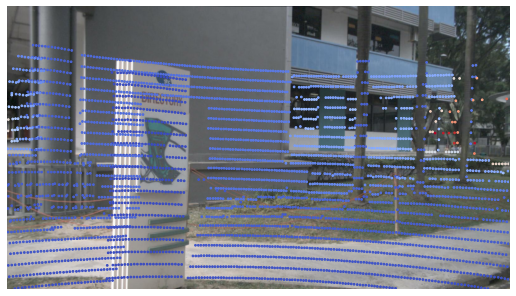

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depth'][0].numpy()
debug_d = data['debug_d'][0]

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


ax.axis('off')

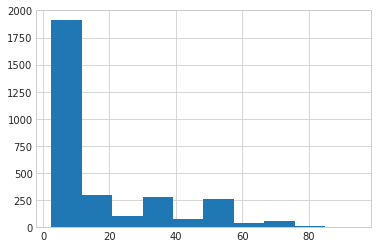

In [ ]:
plt.hist(depth_filter)
plt.show()